# Examen Parcial:

Para ejecutar el código: crear un kernel en la competencia de kaggle (https://www.kaggle.com/c/facial-keypoints-detection) y partir de este notebook. Una vez terminado, se debe descargar el notebook final y subirlo en paideia.


## Descripcion de la tarea

El objetivo de esta tarea es predecir las posiciones de los puntos clave en imágenes de rostros.

Las imágenes de entrada son de 96x96 píxeles y en escala de grises (descritas con números enteros entre 0 y 255).

Cada punto clave se especifica mediante un par de valores reales (x, y) en el espacio de los índices de píxeles. Hay 15 puntos clave, que representan los siguientes elementos de la cara:

    left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

De modo que se debe entrenar una red neuronal que tome como input la imagen en escala de grises y de como output 30 números (las coordenadas x,y de los 15 puntos claves).

Al compilar el modelo, especificar como función de pérdida el mean squared error **(mse)** y como métrica el mean absolute error **(mae)**. Por ejemplo:
``` python
model.compile(Adam(lr), loss='mse', metrics=['mae'])
```

## Calificación

- Normalizar las imágenes (1 pt)
- Definir correctamente la red neuronal (4 pts)
- Entrenar la red neuronal (2 pts)
  - mae entre 10 y 15 (3 pts)
  - mae entre 8 y 11 (5 pts)
  - mae entre 5 y 8 (7 pts)
  - mae menor o igual a 4.0 (9 pts)
- Mostrar 5 resultados aleatorios del set de validación (1 pt)
- Mostrar las 5 mejores predicciones del set de validación (1 pt)
- Mostrar las 5 peores predicciones del set de validación (1 pt)

## Recomendaciones

Activar el uso de GPU en el kernel de kaggle.

Dentro del kernel de kaggle, los botones para bajar y subir kernels, se encuentran en la parte superior de la pagina, a la izquierda del boton commit.

![](https://i.imgur.com/m4inkg3.png)

# Lectura de datos

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('../input/training/training.csv')
df.dropna(inplace=True)
df.shape

In [ ]:
from joblib import Parallel, delayed

def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    x = ex(delayed(format_img)(e) for e in df.Image)
    
x = np.stack(x)[..., None]
x.shape

In [ ]:
y = df.iloc[:, :-1].values
y.shape

In [ ]:
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color='red')
        
    plt.axis('off')

sample_idx = np.random.choice(len(x))    
show(x[sample_idx], y[sample_idx])

# Train validation split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape)
# Normalizar las imágenes (1pt)
# se normalizó las imágenes en valores entre 0 y 1 ya que se conocáa el rango de valores posibles que podía tener cada pixel (0 a 255)
x_train = np.asarray([np.true_divide(x,[255.0],out=None) for x in x_train]) # metodo np.true_divide obtenido de https://stackoverflow.com/a/50324523
x_val = np.asarray([np.true_divide(x,[255.0],out=None) for x in x_val])
print(x_train.shape, x_val.shape)

# Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, add

In [59]:
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Lambda

In [ ]:
y_train.shape

In [67]:
# Definir correctamente la red neuronal (5 pts)
layers = {}
n_layers = 4
nf = 16

m_in = Input((96,96,1)) # capa básica para ingresar datos
# las capas convolucionales sirvieron para analizar los patrones que se encuentran cerca de los puntos de interés
# el código fue extraído del notebook Caravanas de Renato H.
layers[0] = Conv2D(nf, 3, padding='same')(m_in) 
layers[1] = Conv2D(nf*2, 3, strides=(2,2), padding='same', activation='relu')(layers[0])
layers[2] = Conv2D(nf*4, 3, strides=(2,2), padding='same', activation='relu')(layers[1])
# No se utilizaron las capas para volver a las dimensiones iniciales ya que solo se busca analizar los patrones
layers[3]= Dense(units=y_train.shape[1])(layers[2]) # usualmente se usa una capa densa para terminar de conectar los resultados
layers[4] = Flatten()(layers[3]) # se usó flatten para convertir los resultados a 1 dimensión
m_out = Dense(units=y_train.shape[1])(layers[4]) # y finalmente una nueva capa densa para transformar los resultados a la forma de y (30,)

#m_out = Dropout(0.1)(layers[2])


In [68]:
model = Model(m_in, m_out)
model.compile('adam', loss='mse', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 96, 96, 16)        160       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dense_9 (Dense)              (None, 24, 24, 30)        1950      
_________________________________________________________________
flatten_11 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                518430    
Total para

In [69]:
# Entrenar la red neuronal (2 pts)
bs = 128
log = model.fit(x_train, y_train, bs, epochs=5, validation_data=[x_val, y_val])

Train on 1712 samples, validate on 428 samples
Epoch 1/5
1712/1712 [==============================] - 4s 2ms/step - loss: 1416.3709 - mean_absolute_error: 31.5281 - val_loss: 151.5343 - val_mean_absolute_error: 9.1937
Epoch 2/5
1712/1712 [==============================] - 1s 532us/step - loss: 235.0917 - mean_absolute_error: 12.8326 - val_loss: 154.4575 - val_mean_absolute_error: 9.4422
Epoch 3/5
1712/1712 [==============================] - 1s 533us/step - loss: 117.9870 - mean_absolute_error: 8.3249 - val_loss: 79.4226 - val_mean_absolute_error: 6.7276
Epoch 4/5
1712/1712 [==============================] - 1s 533us/step - loss: 41.8476 - mean_absolute_error: 4.8292 - val_loss: 13.9217 - val_mean_absolute_error: 2.8885
Epoch 5/5
1712/1712 [==============================] - 1s 528us/step - loss: 14.0121 - mean_absolute_error: 2.7863 - val_loss: 11.8481 - val_mean_absolute_error: 2.5577


In [70]:
# Resultado del entrenamiento
# - mae entre 10 y 15 (3 pts)
# - mae entre 8 y 11 (5 pts)
# - mae entre 5 y 8 (7 pts)
# - mae menor o igual a 4.0 (9 pts)

print(f'MAE final: {model.evaluate(x_val, y_val)[1]}')

428/428 [==============================] - 0s 506us/step
MAE final: 2.557696175352435


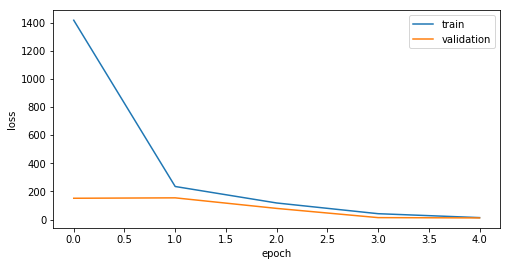

In [71]:
# Ver la perdida en el entrenamiento
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [], [], [], []
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(trn_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss')
    ax.legend()
    
show_results(log)

# Resultados

In [72]:
# Función para visualizar un resultado
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

Ej:
``` python
sample_x = x_val[0, None]
sample_y = y_val[0, None]
pred = model.predict(sample_x)
show_pred(sample_x, sample_y, pred)
```

In [76]:
import random


259

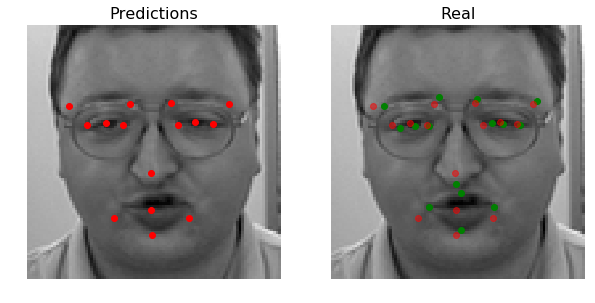

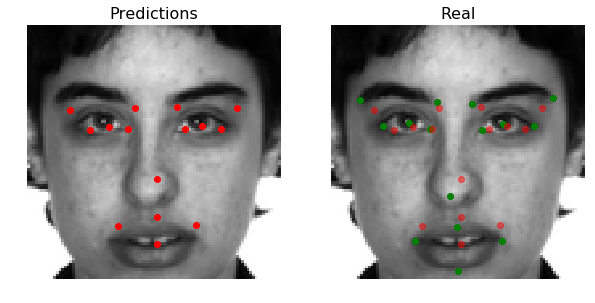

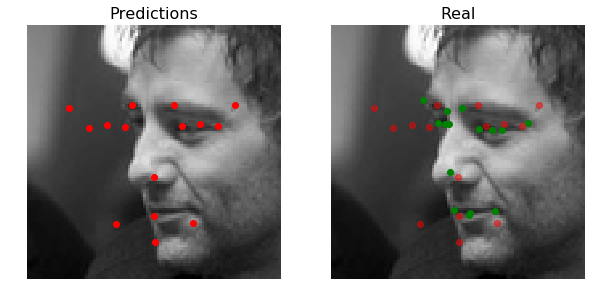

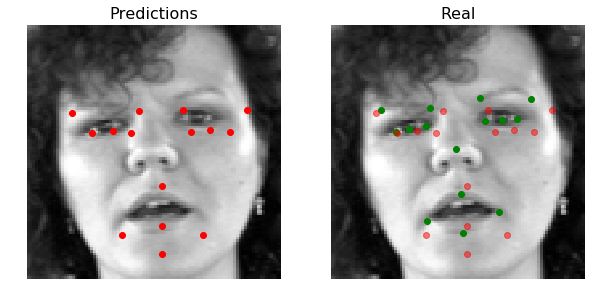

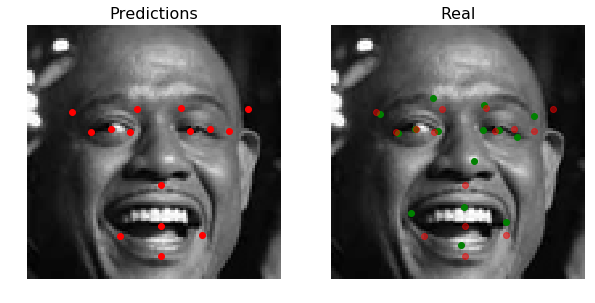

In [78]:
# Mostrar 5 resultados aleatorios del set de validación (1 pt)
for i in [random.randint(0,x_val.shape[0]) for x in range(0,5)]:
    sample_x = x_val[i, None]
    sample_y = y_val[i, None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

In [81]:
guys = np.array([1,2,3])

In [89]:
mse

0.0

In [98]:
# mediremos el error cuadratico de cada predicción para conocer el top y bottom, respectivamente
y_mse = []
for i in range(0,x_val.shape[0]):
    sample_x = x_val[i, None]
    sample_y = y_val[i, None]
    pred = model.predict(sample_x)
    y_mse.append([i, ((sample_y-pred)[0]**2).mean(axis=0)]) # adaptado de https://stackoverflow.com/a/18047482
    print("measured mse for index ",i)


measured mse for index  0
measured mse for index  1
measured mse for index  2
measured mse for index  3
measured mse for index  4
measured mse for index  5
measured mse for index  6
measured mse for index  7
measured mse for index  8
measured mse for index  9
measured mse for index  10
measured mse for index  11
measured mse for index  12
measured mse for index  13
measured mse for index  14
measured mse for index  15
measured mse for index  16
measured mse for index  17
measured mse for index  18
measured mse for index  19
measured mse for index  20
measured mse for index  21
measured mse for index  22
measured mse for index  23
measured mse for index  24
measured mse for index  25
measured mse for index  26
measured mse for index  27
measured mse for index  28
measured mse for index  29
measured mse for index  30
measured mse for index  31
measured mse for index  32
measured mse for index  33
measured mse for index  34
measured mse for index  35
measured mse for index  36
measured ms

measured mse for index  336
measured mse for index  337
measured mse for index  338
measured mse for index  339
measured mse for index  340
measured mse for index  341
measured mse for index  342
measured mse for index  343
measured mse for index  344
measured mse for index  345
measured mse for index  346
measured mse for index  347
measured mse for index  348
measured mse for index  349
measured mse for index  350
measured mse for index  351
measured mse for index  352
measured mse for index  353
measured mse for index  354
measured mse for index  355
measured mse for index  356
measured mse for index  357
measured mse for index  358
measured mse for index  359
measured mse for index  360
measured mse for index  361
measured mse for index  362
measured mse for index  363
measured mse for index  364
measured mse for index  365
measured mse for index  366
measured mse for index  367
measured mse for index  368
measured mse for index  369
measured mse for index  370
measured mse for ind

In [103]:
# ordenaremos el arreglo de menor a mayor
y_mse = sorted(y_mse, key = lambda x: x[1], reverse=False)

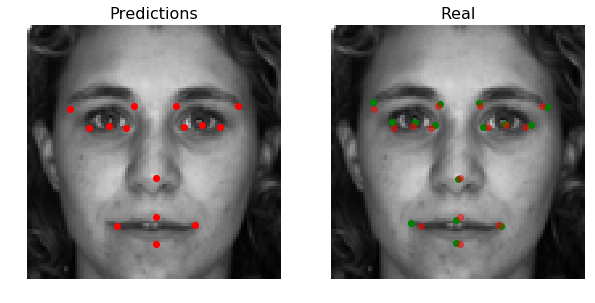

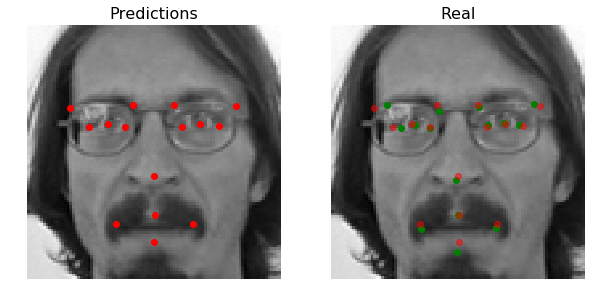

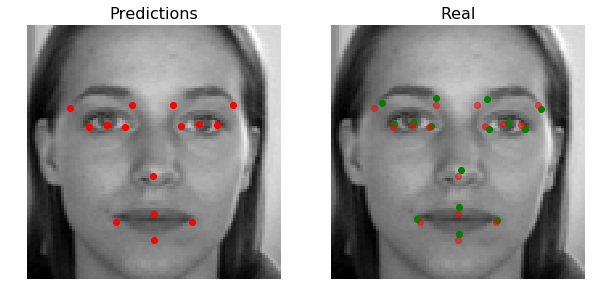

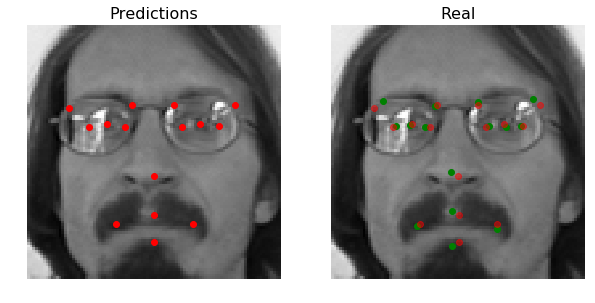

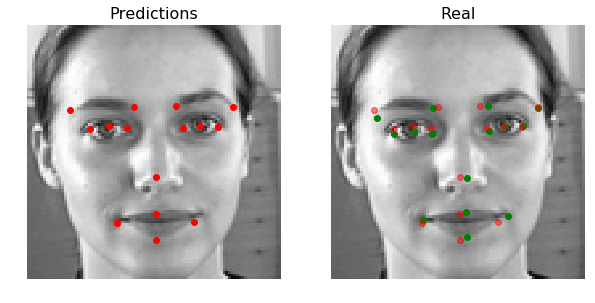

In [106]:
# Mostrar las 5 mejores predicciones del set de validación (1 pt)
for j in range(0,5):
    i = y_mse[j][0]
    sample_x = x_val[i, None]
    sample_y = y_val[i, None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

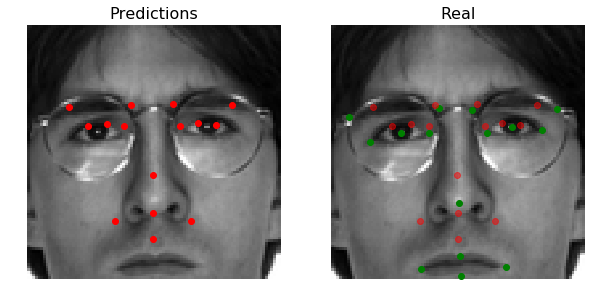

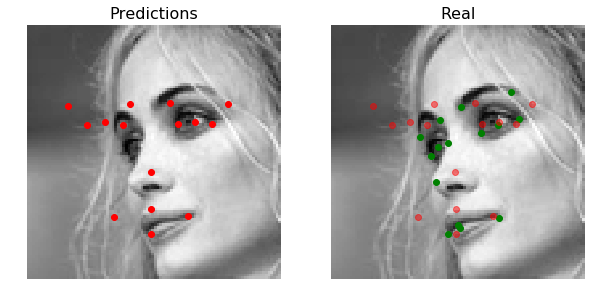

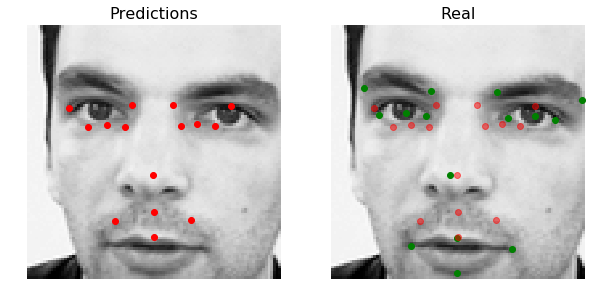

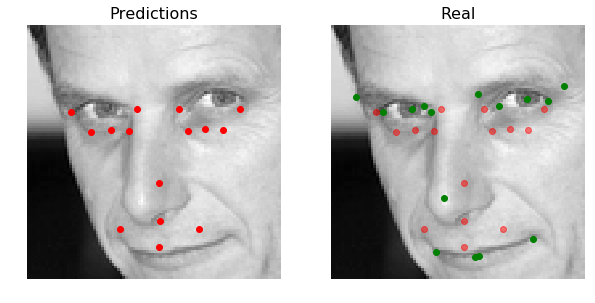

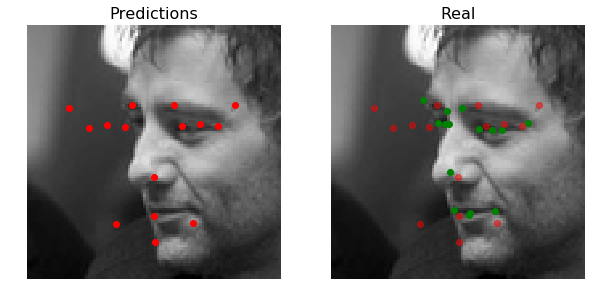

In [107]:
# Mostrar las 5 peores predicciones del set de validación (1 pt)
for j in range(1,6):
    i = y_mse[-j][0]
    sample_x = x_val[i, None]
    sample_y = y_val[i, None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)